# Train a model using only the train dataset

In [1]:
import json
import os
import pickle
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shap
import torch
from shap import DeepExplainer
from sklearn.model_selection import KFold

sys.path.insert(0, "/mnt/c/Users/nick/Desktop/corsello_lab/refract")
import argparse
import logging

from refract.datasets import PrismDataset
from refract.losses import lambdaLoss
from refract.metrics import get_stringdb_network_interactions
from refract.models import FeedForwardNet
from refract.ranking_trainers import NNRankerTrainer

from scipy.stats import pearsonr

/home/nphillips/miniconda3/envs/corlab/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
NUM_FEATURES = 100
SLATE_LENGTH = 10
NUM_EPOCHS = 50
BATCH_SIZE = 512

In [3]:
response_train = pd.read_csv("dfs/response_train.csv")

In [4]:
feature_train = pd.read_csv("dfs/feature_train.csv", index_col=0)

In [5]:
compound_name = "caramiphen"
feature_importance_path = f"/mnt/c/Users/nick/Desktop/corsello_lab/refract/notebooks/20230607_validate_performance/feature_importance_paths/{compound_name}.csv"
feature_importance_df = pd.read_csv(feature_importance_path)

In [6]:
ds_train = PrismDataset(
    response_train,
    feature_train,
    feature_importance_df,
    top_k_features=NUM_FEATURES,
    slate_length=SLATE_LENGTH
)


In [7]:
model = FeedForwardNet(NUM_FEATURES)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
trainer = NNRankerTrainer(model, optimizer)

In [8]:
trainer.train(ds_train, BATCH_SIZE, NUM_EPOCHS)

In [9]:
train_ccle_names, train_preds, train_trues, train_corr = trainer.eval(ds_train)
print("R train: ", train_corr)

R train:  (0.5832860012918372, 1.1978423951608187e-40)


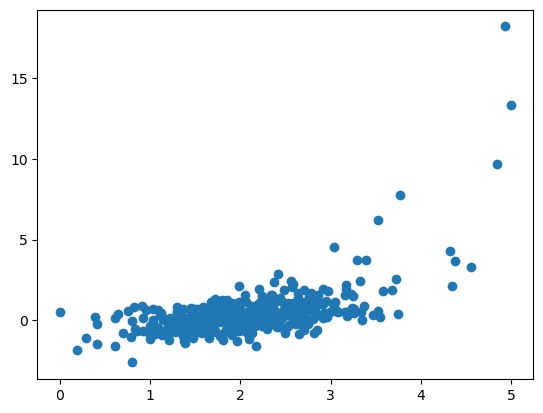

In [10]:
import matplotlib.pyplot as plt
plt.scatter(train_trues, train_preds)

In [11]:
# save the model to disk
torch.save(model.state_dict(), f"models/{compound_name}.pt")

In [12]:
# save train ds feature transformer
with open("train_feature_transformer.pkl", "wb") as f:
    pickle.dump(ds_train.feature_transformer, f)